In [2]:
#Importing all the necessary librariries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import L1L2
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('E:/Whitecliffe Seminars/Final_Semester/Dataset/weather_data_1hr.csv')
df.head()

,loc_id,date,time,isdaytime,tempC,tempF,windspeedMiles,windspeedKmph,winddirdegree,winddir16point,...,HeatIndexF,DewPointC,DewPointF,WindChillC,WindChillF,WindGustMiles,WindGustKmph,FeelsLikeC,FeelsLikeF,uvIndex
0,1,2021-01-01,0,no,18,64,2,4,276,W,...,64,15,58,18,64,5,8,18,64,1
1,1,2021-01-01,100,no,18,64,2,3,278,W,...,64,15,58,18,64,5,7,18,64,1
2,1,2021-01-01,200,no,17,63,1,2,280,W,...,63,14,58,17,63,4,7,17,63,1
3,1,2021-01-01,300,no,17,63,1,2,282,WNW,...,63,14,58,17,63,4,7,17,63,1
4,1,2021-01-01,400,no,17,63,1,2,280,W,...,63,14,57,17,63,4,6,17,63,1


In [4]:
df.shape

(37440, 32)

In [5]:
#Padding the time column to 4 characters
df['time'] = df['time'].astype(str).str.zfill(4)

#Concatenating padded time and date column 
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'].str[:2] + ':00')

df.head()


,loc_id,date,time,isdaytime,tempC,tempF,windspeedMiles,windspeedKmph,winddirdegree,winddir16point,...,DewPointC,DewPointF,WindChillC,WindChillF,WindGustMiles,WindGustKmph,FeelsLikeC,FeelsLikeF,uvIndex,datetime
0,1,2021-01-01,0000,no,18,64,2,4,276,W,...,15,58,18,64,5,8,18,64,1,2021-01-01 00:00:00
1,1,2021-01-01,0100,no,18,64,2,3,278,W,...,15,58,18,64,5,7,18,64,1,2021-01-01 01:00:00
2,1,2021-01-01,0200,no,17,63,1,2,280,W,...,14,58,17,63,4,7,17,63,1,2021-01-01 02:00:00
3,1,2021-01-01,0300,no,17,63,1,2,282,WNW,...,14,58,17,63,4,7,17,63,1,2021-01-01 03:00:00
4,1,2021-01-01,0400,no,17,63,1,2,280,W,...,14,57,17,63,4,6,17,63,1,2021-01-01 04:00:00


In [6]:
#Dropping the date and time columns
df.drop(['date', 'time'], axis=1, inplace=True)

In [7]:
#Setting datetime column as index as it is good for time series analysis
df.set_index('datetime', inplace=True)

df.tail(10)

,loc_id,isdaytime,tempC,tempF,windspeedMiles,windspeedKmph,winddirdegree,winddir16point,weatherCode,weatherIconUrl,...,HeatIndexF,DewPointC,DewPointF,WindChillC,WindChillF,WindGustMiles,WindGustKmph,FeelsLikeC,FeelsLikeF,uvIndex
datetime,,,,,,,,,,,,,,,,,,,,,
2025-04-09 14:00:00,1,yes,18,65,13,21,219,SW,113,https://cdn.worldweatheronline.com/images/wsym...,...,65,8,47,18,65,15,24,18,65,5
2025-04-09 15:00:00,1,yes,18,64,14,22,216,SW,113,https://cdn.worldweatheronline.com/images/wsym...,...,64,8,46,18,64,16,26,18,64,5
2025-04-09 16:00:00,1,yes,18,64,13,21,215,SW,113,https://cdn.worldweatheronline.com/images/wsym...,...,64,8,47,18,64,16,25,18,64,5
2025-04-09 17:00:00,1,yes,17,63,12,19,212,SSW,113,https://cdn.worldweatheronline.com/images/wsym...,...,63,9,47,17,63,15,25,17,63,5
2025-04-09 18:00:00,1,yes,16,61,10,16,207,SSW,113,https://cdn.worldweatheronline.com/images/wsym...,...,61,9,48,16,61,15,24,16,61,5
2025-04-09 19:00:00,1,no,15,59,8,13,203,SSW,116,https://cdn.worldweatheronline.com/images/wsym...,...,59,9,49,15,59,13,21,15,59,1
2025-04-09 20:00:00,1,no,15,58,7,12,196,SSW,113,https://cdn.worldweatheronline.com/images/wsym...,...,58,10,49,14,57,12,19,14,57,1
2025-04-09 21:00:00,1,no,14,58,6,10,192,SSW,113,https://cdn.worldweatheronline.com/images/wsym...,...,58,10,49,14,57,11,18,14,57,1
2025-04-09 22:00:00,1,no,14,58,5,8,195,SSW,113,https://cdn.worldweatheronline.com/images/wsym...,...,58,10,49,14,57,9,14,14,57,1


In [8]:
df.isna().sum()

loc_id             0
isdaytime          0
tempC              0
tempF              0
windspeedMiles     0
windspeedKmph      0
winddirdegree      0
winddir16point     0
weatherCode        0
weatherIconUrl     0
weatherDesc        0
precipMM           0
precipInches       0
humidity           0
visibilityKm       0
visibilityMiles    0
pressureMB         0
pressureInches     0
cloudcover         0
HeatIndexC         0
HeatIndexF         0
DewPointC          0
DewPointF          0
WindChillC         0
WindChillF         0
WindGustMiles      0
WindGustKmph       0
FeelsLikeC         0
FeelsLikeF         0
uvIndex            0
dtype: int64

### Univaraite Analysis

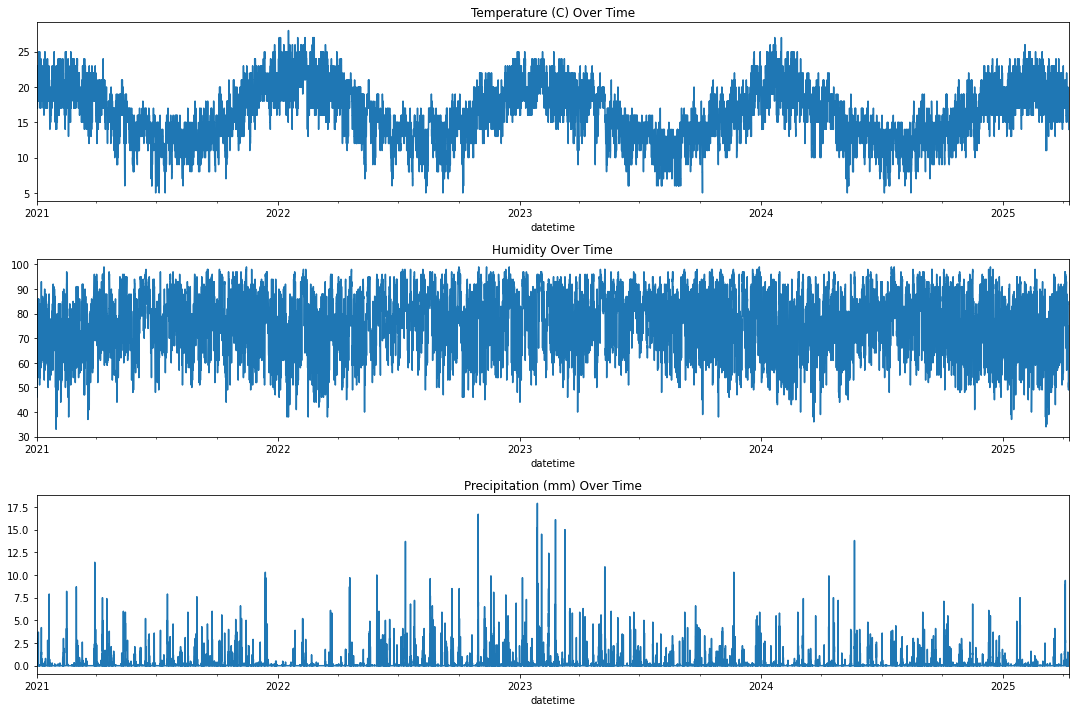

In [9]:
plt.figure(figsize=(15, 10))
plt.subplot(3, 1, 1)
df['tempC'].plot(title='Temperature (C) Over Time')
plt.subplot(3, 1, 2)
df['humidity'].plot(title='Humidity Over Time')
plt.subplot(3, 1, 3)
df['precipMM'].plot(title='Precipitation (mm) Over Time')
plt.tight_layout()
plt.show()

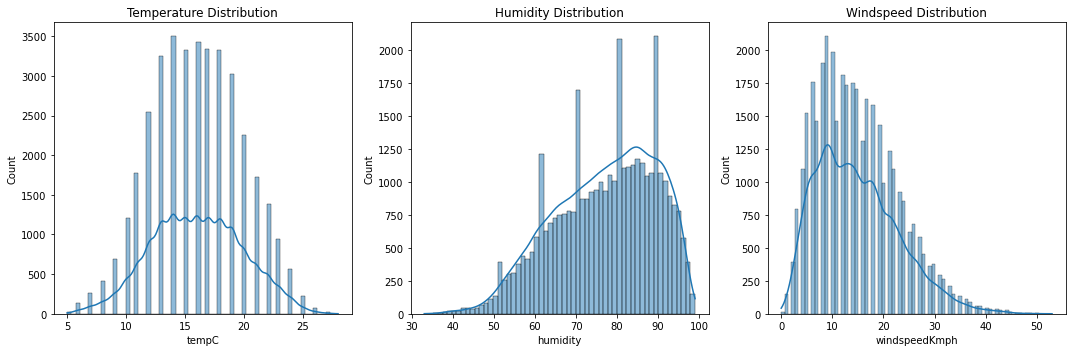

In [10]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(df['tempC'], kde=True)
plt.title('Temperature Distribution')
plt.subplot(1, 3, 2)
sns.histplot(df['humidity'], kde=True)
plt.title('Humidity Distribution')
plt.subplot(1, 3, 3)
sns.histplot(df['windspeedKmph'], kde=True)
plt.title('Windspeed Distribution')
plt.tight_layout()
plt.show()

### Bi-Variate Analysis

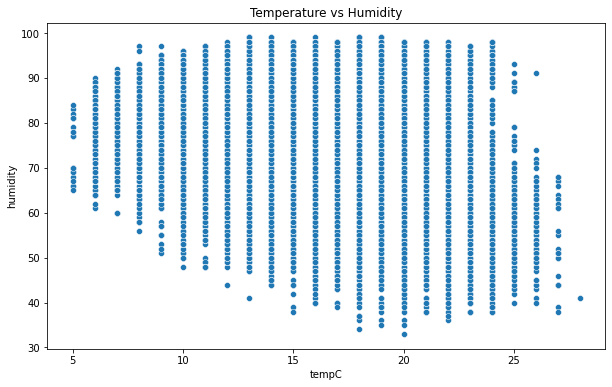

In [11]:
# Temperature vs Humidity
plt.figure(figsize=(10, 6))
sns.scatterplot(x='tempC', y='humidity', data=df)
plt.title('Temperature vs Humidity')
plt.show()

### Multi-Variate Analysis

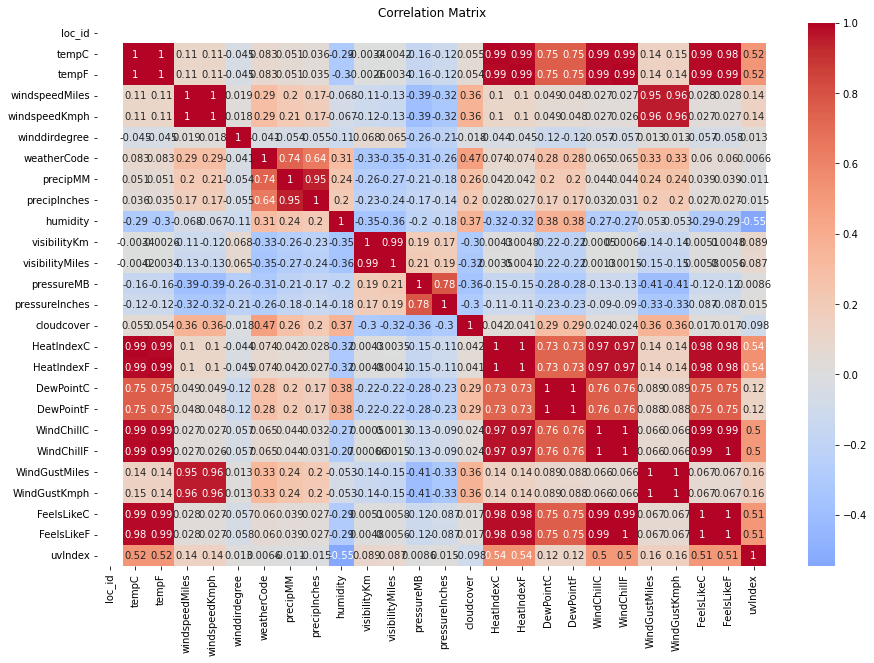

In [12]:
# Correlation between numerical features
corr_matrix = df.select_dtypes(include=['float64', 'int64']).corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

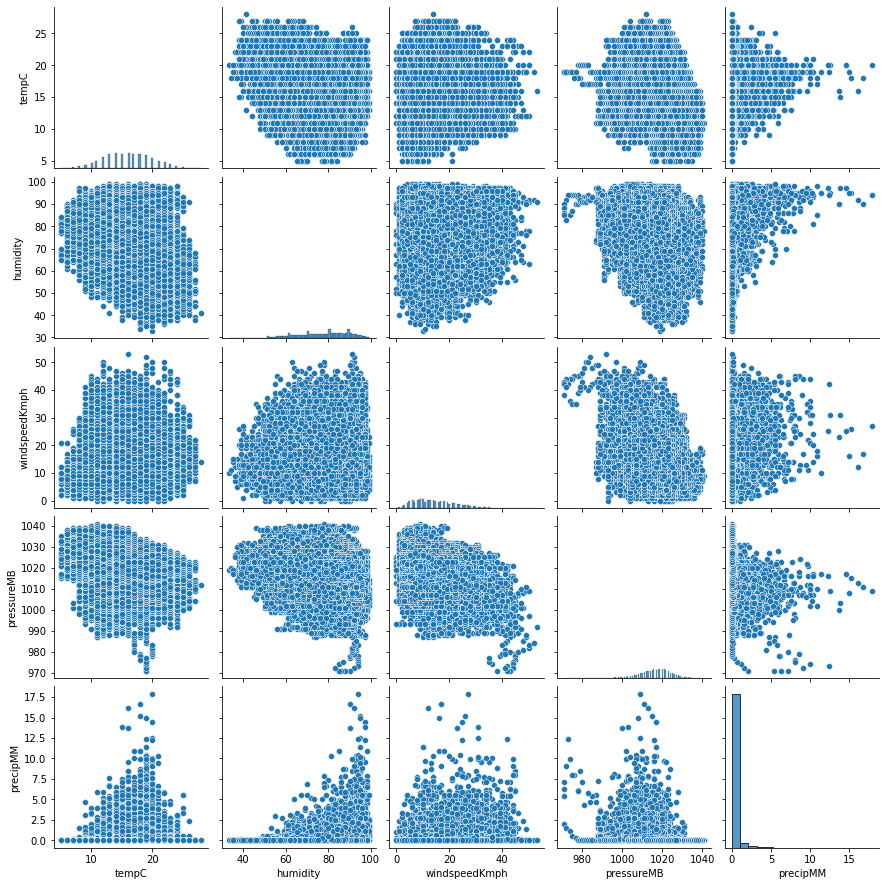

In [13]:
# Pairplot of key variables
sns.pairplot(df[['tempC', 'humidity', 'windspeedKmph', 'pressureMB', 'precipMM']])
plt.show()


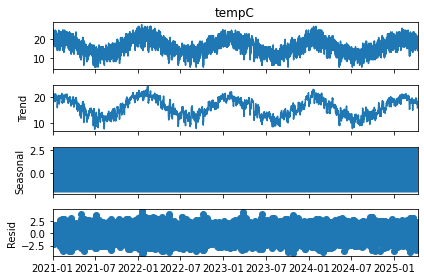

In [14]:
# Time series decomposition for temperature
result = seasonal_decompose(df['tempC'], model='additive', period=24) # Daily seasonality
result.plot()
plt.show()

In [15]:
df.describe()

,loc_id,tempC,tempF,windspeedMiles,windspeedKmph,winddirdegree,weatherCode,precipMM,precipInches,humidity,...,HeatIndexF,DewPointC,DewPointF,WindChillC,WindChillF,WindGustMiles,WindGustKmph,FeelsLikeC,FeelsLikeF,uvIndex
count,37440.0,37440.000000,37440.000000,37440.000000,37440.000000,37440.000000,37440.000000,37440.000000,37440.000000,37440.000000,...,37440.000000,37440.000000,37440.000000,37440.000000,37440.000000,37440.000000,37440.000000,37440.000000,37440.000000,37440.000000
mean,1.0,16.020326,60.811538,9.241506,14.867041,175.182906,143.742788,0.183854,0.005542,77.039663,...,61.247569,11.821261,53.250881,15.497756,59.884749,15.868937,25.540358,15.627244,60.100160,2.683974
std,0.0,3.858946,6.933110,5.005017,8.034090,97.527022,60.224304,0.721289,0.029698,12.273524,...,7.720913,3.677037,6.608185,4.426173,7.946766,8.089677,13.015782,4.667764,8.351071,1.819676
min,1.0,5.000000,41.000000,0.000000,0.000000,0.000000,113.000000,0.000000,0.000000,33.000000,...,41.000000,-1.000000,31.000000,1.000000,34.000000,0.000000,1.000000,1.000000,34.000000,1.000000
25%,1.0,13.000000,56.000000,5.000000,9.000000,79.000000,113.000000,0.000000,0.000000,68.000000,...,56.000000,9.000000,49.000000,12.000000,54.000000,10.000000,15.000000,12.000000,54.000000,1.000000
50%,1.0,16.000000,61.000000,9.000000,14.000000,208.000000,119.000000,0.000000,0.000000,78.000000,...,61.000000,12.000000,54.000000,16.000000,61.000000,15.000000,24.000000,16.000000,61.000000,1.500000
75%,1.0,19.000000,66.000000,12.000000,20.000000,244.000000,122.000000,0.000000,0.000000,87.000000,...,66.000000,15.000000,58.000000,19.000000,66.000000,21.000000,34.000000,19.000000,66.000000,4.000000
max,1.0,28.000000,82.000000,33.000000,53.000000,360.000000,356.000000,17.900000,0.700000,99.000000,...,85.000000,23.000000,73.000000,28.000000,82.000000,53.000000,86.000000,30.000000,85.000000,7.000000


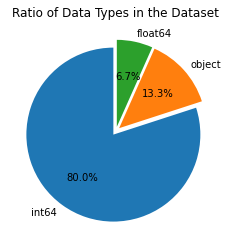

In [16]:
dtype_counts = df.dtypes.value_counts() #Creating a list to add datatype counts

explode = [0.05] * len(dtype_counts)  # Exploding function to slice each part for better visuals

plt.figure(figsize=(6, 4))
plt.pie(dtype_counts.values, labels=dtype_counts.index.astype(str), autopct='%1.1f%%', 
        startangle=90, explode = explode)
plt.title("Ratio of Data Types in the Dataset")
plt.show()

In [17]:
df.dtypes

loc_id               int64
isdaytime           object
tempC                int64
tempF                int64
windspeedMiles       int64
windspeedKmph        int64
winddirdegree        int64
winddir16point      object
weatherCode          int64
weatherIconUrl      object
weatherDesc         object
precipMM           float64
precipInches       float64
humidity             int64
visibilityKm         int64
visibilityMiles      int64
pressureMB           int64
pressureInches       int64
cloudcover           int64
HeatIndexC           int64
HeatIndexF           int64
DewPointC            int64
DewPointF            int64
WindChillC           int64
WindChillF           int64
WindGustMiles        int64
WindGustKmph         int64
FeelsLikeC           int64
FeelsLikeF           int64
uvIndex              int64
dtype: object

In [18]:
df.columns

Index(['loc_id', 'isdaytime', 'tempC', 'tempF', 'windspeedMiles',
       'windspeedKmph', 'winddirdegree', 'winddir16point', 'weatherCode',
       'weatherIconUrl', 'weatherDesc', 'precipMM', 'precipInches', 'humidity',
       'visibilityKm', 'visibilityMiles', 'pressureMB', 'pressureInches',
       'cloudcover', 'HeatIndexC', 'HeatIndexF', 'DewPointC', 'DewPointF',
       'WindChillC', 'WindChillF', 'WindGustMiles', 'WindGustKmph',
       'FeelsLikeC', 'FeelsLikeF', 'uvIndex'],
      dtype='object')

Label Encoding

In [19]:
categorical_columns = ['isdaytime', 'weatherDesc', 'winddir16point']
le = LabelEncoder()
for col in categorical_columns:
    df[col] = le.fit_transform(df[col].astype(str))


In [20]:
df.head()

,loc_id,isdaytime,tempC,tempF,windspeedMiles,windspeedKmph,winddirdegree,winddir16point,weatherCode,weatherIconUrl,...,HeatIndexF,DewPointC,DewPointF,WindChillC,WindChillF,WindGustMiles,WindGustKmph,FeelsLikeC,FeelsLikeF,uvIndex
datetime,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,1,0,18,64,2,4,276,13,113,https://cdn.worldweatheronline.com/images/wsym...,...,64,15,58,18,64,5,8,18,64,1
2021-01-01 01:00:00,1,0,18,64,2,3,278,13,113,https://cdn.worldweatheronline.com/images/wsym...,...,64,15,58,18,64,5,7,18,64,1
2021-01-01 02:00:00,1,0,17,63,1,2,280,13,113,https://cdn.worldweatheronline.com/images/wsym...,...,63,14,58,17,63,4,7,17,63,1
2021-01-01 03:00:00,1,0,17,63,1,2,282,14,113,https://cdn.worldweatheronline.com/images/wsym...,...,63,14,58,17,63,4,7,17,63,1
2021-01-01 04:00:00,1,0,17,63,1,2,280,13,113,https://cdn.worldweatheronline.com/images/wsym...,...,63,14,57,17,63,4,6,17,63,1


## LSTM Modelling

In [21]:
# Select final features based on importance and correlation
final_features = ['isdaytime','windspeedKmph', 'winddirdegree', 'winddir16point',
                  'weatherDesc', 'precipMM', 'humidity','visibilityKm', 'pressureMB', 
                  'cloudcover', 'HeatIndexC', 'DewPointC','WindChillC', 'WindGustKmph',
                  'FeelsLikeC', 'uvIndex']

# Create final dataset
final_df = df[['tempC'] + list(final_features)]

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(final_df)

In [22]:
# Creating sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length-1):
        X.append(data[i:(i+seq_length), :])
        y.append(data[i+seq_length, 0])  # tempC is our target
    return np.array(X), np.array(y)

seq_length = 24  # 24 hours lookback
X, y = create_sequences(scaled_data, seq_length)

# Split into train and test
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training shape: {X_train.shape}, {y_train.shape}")
print(f"Testing shape: {X_test.shape}, {y_test.shape}")

Training shape: (29932, 24, 17), (29932,)
Testing shape: (7483, 24, 17), (7483,)


In [23]:
# Building LSTM model with 2 dropout layers
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define the checkpoint path
checkpoint_path = "best_weights.weights.h5"

# Create ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1
)

# Train the model with both callbacks
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint],  # Added checkpoint callback
    verbose=1
)



Epoch 1/50
936/936 [==============================] - ETA: 0s - loss: 0.0052
Epoch 1: val_loss improved from inf to 0.00174, saving model to best_weights.weights.h5
936/936 [==============================] - 31s 26ms/step - loss: 0.0052 - val_loss: 0.0017
Epoch 2/50
934/936 [============================>.] - ETA: 0s - loss: 0.0023
Epoch 2: val_loss improved from 0.00174 to 0.00094, saving model to best_weights.weights.h5
936/936 [==============================] - 20s 21ms/step - loss: 0.0023 - val_loss: 9.3837e-04
Epoch 3/50
934/936 [============================>.] - ETA: 0s - loss: 0.0018
Epoch 3: val_loss improved from 0.00094 to 0.00080, saving model to best_weights.weights.h5
936/936 [==============================] - 19s 20ms/step - loss: 0.0018 - val_loss: 7.9542e-04
Epoch 4/50
934/936 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 4: val_loss improved from 0.00080 to 0.00072, saving model to best_weights.weights.h5
936/936 [==============================] - 20s 

Final model weights saved to final_weights.weights.h5
Complete model saved to complete_model.h5


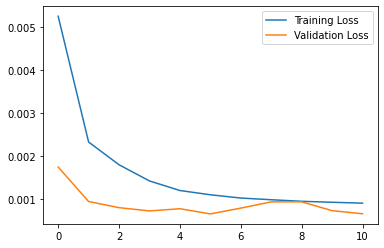

In [24]:
# After training completes, saving the final weights
final_weights_path = "final_weights.weights.h5"
model.save_weights(final_weights_path)
print(f"Final model weights saved to {final_weights_path}")

#Saving the weights
model.save("complete_model.h5")
print("Complete model saved to complete_model.h5")

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 128)           74752     
                                                                 
 dropout (Dropout)           (None, 24, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 124,225
Trainable params: 124,225
Non-trainable params: 0
_________________________________________________________________


234/234 [==============================] - 3s 7ms/step
Test RMSE (from January 2025): 0.60°C


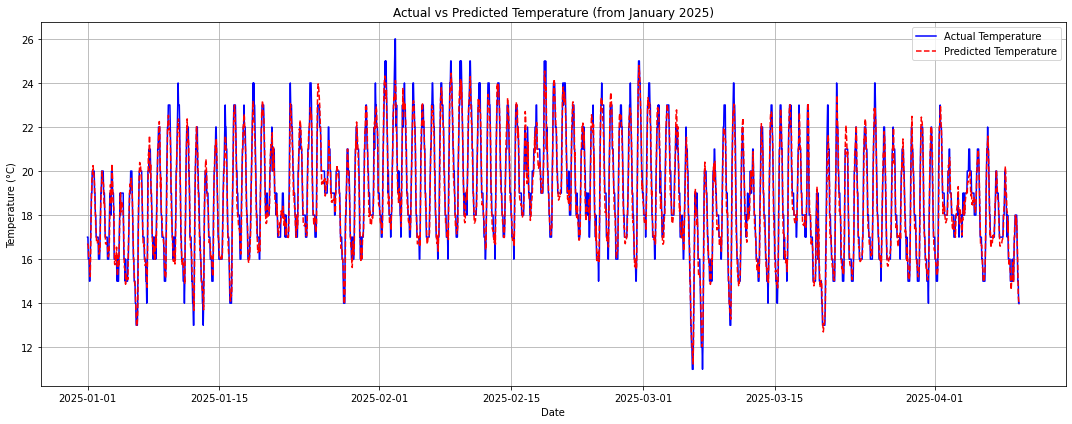

In [26]:
# Make predictions
predictions = model.predict(X_test)

y_test_inv_full = scaler.inverse_transform(
    np.concatenate([y_test.reshape(-1, 1), X_test[:, -1, 1:]], axis=1)
)[:, 0]

predictions_inv_full = scaler.inverse_transform(
    np.concatenate([predictions.reshape(-1, 1), X_test[:, -1, 1:]], axis=1)
)[:, 0]

test_start_index = df.index.get_loc(df[df.index >= '2025-01-01'].index[0])

window = 7 
test_start = len(df) - len(y_test) - window
prediction_dates = df.index[test_start + window : test_start + window + len(y_test)]

y_test_inv_full = scaler.inverse_transform(
    np.concatenate([y_test.reshape(-1, 1), X_test[:, -1, 1:]], axis=1)
)[:, 0]

predictions_inv_full = scaler.inverse_transform(
    np.concatenate([predictions.reshape(-1, 1), X_test[:, -1, 1:]], axis=1)
)[:, 0]

mask = prediction_dates >= pd.to_datetime("2025-01-01")
filtered_dates = prediction_dates[mask]
filtered_actual = y_test_inv_full[mask]
filtered_predicted = predictions_inv_full[mask]



rmse_jan = np.sqrt(mean_squared_error(filtered_actual, filtered_predicted))
print(f"Test RMSE (from January 2025): {rmse_jan:.2f}°C")

plt.figure(figsize=(15, 6))
plt.plot(filtered_dates, filtered_actual, label='Actual Temperature', color='blue')
plt.plot(filtered_dates, filtered_predicted, label='Predicted Temperature', color='red', linestyle='--')
plt.title('Actual vs Predicted Temperature (from January 2025)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

predictions = model.predict(X_test)
# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error (MAE): {mae}")

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error (MSE): {mse}")

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

mean_actual = np.mean(y_test)
accuracy_percent = 100 - (rmse / mean_actual) * 100
print(f"Accuracy: {accuracy_percent:.2f}%")

234/234 [==============================] - 2s 7ms/step
Mean Absolute Error (MAE): 0.0195518719761874
Mean Squared Error (MSE): 0.0006500244014325011
Root Mean Squared Error (RMSE): 0.02549557611493612
Accuracy: 94.44%


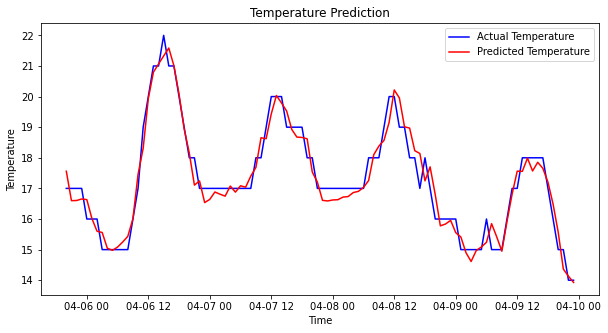

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(df.index[-100:], filtered_actual[-100:],color='blue', label='Actual Temperature')
plt.plot(df.index[-100:], filtered_predicted[-100:], color='red', label='Predicted Temperature')
plt.title('Temperature Prediction')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

### ARIMA Model

In [29]:
dfnew = df['tempC'].resample('D').mean()


In [30]:
dfnew.head()

datetime
2021-01-01    19.958333
2021-01-02    19.916667
2021-01-03    19.875000
2021-01-04    20.916667
2021-01-05    21.416667
Freq: D, Name: tempC, dtype: float64

In [31]:
dfnew.describe()

count    1560.000000
mean       16.020326
std         3.308570
min         8.041667
25%        13.250000
50%        16.041667
75%        18.875000
max        23.958333
Name: tempC, dtype: float64

In [32]:
arima_model = ARIMA(dfnew, order=(7, 0, 15))
arima_result = arima_model.fit()

n_forecast_days = 14
arima_forecast = arima_result.forecast(steps=n_forecast_days)

In [ ]:
actual_vals = dfnew[-n_forecast_days:]  
forecast_vals = arima_forecast[:n_forecast_days]  

# Make sure both have the same length
min_len = min(len(actual_vals), len(forecast_vals))
actual_vals = actual_vals[:min_len]
forecast_vals = forecast_vals[:min_len]

# Compute RMSE
arima_rmse = sqrt(mean_squared_error(actual_vals, forecast_vals))

arima_mse = mean_squared_error(actual_vals, forecast_vals)
arima_rmse = sqrt(arima_mse)
arima_mae = mean_absolute_error(actual_vals, forecast_vals)
mean_actual = np.mean(actual_vals)
arima_accuracy = 100 - (arima_rmse / mean_actual) * 100

# Print results
print(f"ARIMA MSE: {arima_mse:.2f}")
print(f"ARIMA MAE: {arima_mae:.2f}")
print(f"ARIMA RMSE: {arima_rmse:.2f} °C")
print(f"ARIMA Accuracy: {arima_accuracy:.2f}%")

ARIMA MSE: 1.98
ARIMA MAE: 1.28
ARIMA RMSE: 1.41 °C
ARIMA Accuracy: 92.22%


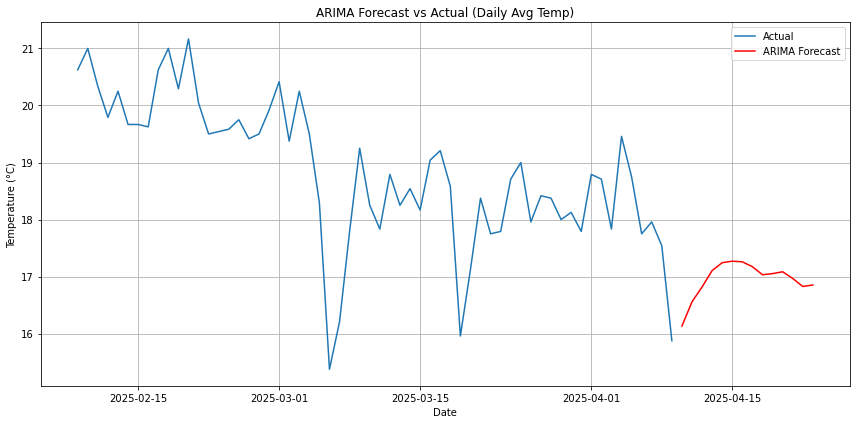

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(dfnew[-60:], label='Actual')
plt.plot(arima_forecast.index, arima_forecast.values, label='ARIMA Forecast', color='red')
plt.title("ARIMA Forecast vs Actual (Daily Avg Temp)")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Hybrid LSTM-ARIMA Model

7 Day Prediction

In [35]:
last_n_hours = 7 * 24
filtered_actual_7d = filtered_actual[-last_n_hours:]
filtered_predicted_7d = filtered_predicted[-last_n_hours:]
filtered_dates_7d = filtered_dates[-last_n_hours:]

residuals_7d = filtered_actual_7d - filtered_predicted_7d


arima_res_model = ARIMA(residuals_7d, order=(7, 0, 15))
arima_res_fit = arima_res_model.fit()


arima_res_forecast = arima_res_fit.forecast(steps=len(filtered_predicted_7d))


hybrid_preds = filtered_predicted_7d + arima_res_forecast

lstm_rmse = sqrt(mean_squared_error(filtered_actual_7d, filtered_predicted_7d))
hybrid_rmse = sqrt(mean_squared_error(filtered_actual_7d, hybrid_preds))

mean_actual = np.mean(filtered_actual_7d)
lstm_accuracy = 100 - (lstm_rmse / mean_actual) * 100
hybrid_accuracy = 100 - (hybrid_rmse / mean_actual) * 100

print(f"LSTM RMSE (7d): {lstm_rmse:.2f}°C | Accuracy: {lstm_accuracy:.2f}%")
print(f"Hybrid RMSE (7d): {hybrid_rmse:.2f}°C | Accuracy: {hybrid_accuracy:.2f}%")





LSTM RMSE (7d): 0.50°C | Accuracy: 97.20%
Hybrid RMSE (7d): 0.50°C | Accuracy: 97.20%


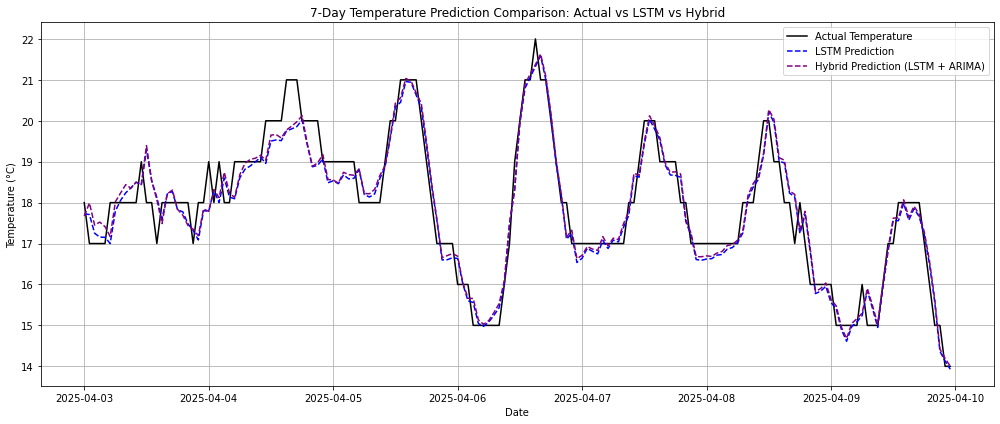

In [36]:
plt.figure(figsize=(14, 6))
plt.plot(filtered_dates_7d, filtered_actual_7d, label='Actual Temperature', color='black')
plt.plot(filtered_dates_7d, filtered_predicted_7d, label='LSTM Prediction', linestyle='--', color='blue')
plt.plot(filtered_dates_7d, hybrid_preds, label='Hybrid Prediction (LSTM + ARIMA)', linestyle='--', color='purple')
plt.title('7-Day Temperature Prediction Comparison: Actual vs LSTM vs Hybrid')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Prediction on overall data & Comparison through plot

Hybrid MSE: 0.36
Hybrid MAE: 0.47
Hybrid RMSE: 0.60°C
Hybrid Accuracy: 96.82%


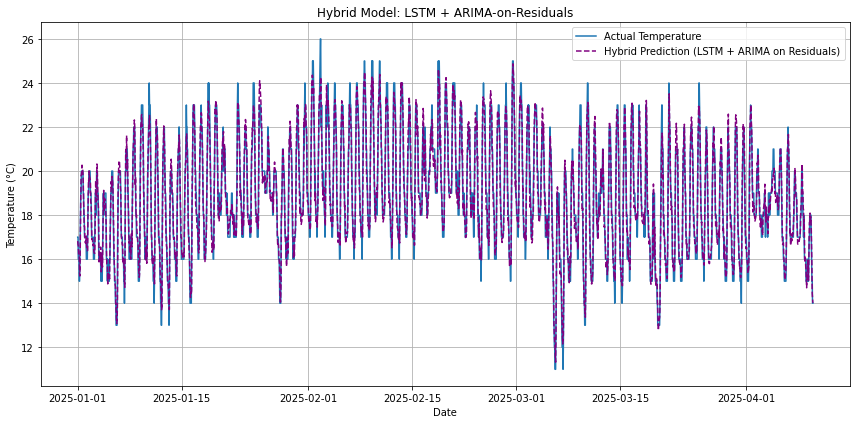

In [38]:
residuals = filtered_actual - filtered_predicted
arima_res_model = ARIMA(residuals, order=(7, 0, 15))
arima_res_fit = arima_res_model.fit()

arima_res_forecast = arima_res_fit.forecast(steps=len(filtered_predicted))



hybrid_preds = filtered_predicted + arima_res_forecast

hybrid_mse = mean_squared_error(filtered_actual, hybrid_preds)
hybrid_rmse = sqrt(hybrid_mse)
hybrid_mae = mean_absolute_error(filtered_actual, hybrid_preds)
mean_actual = np.mean(filtered_actual)
accuracy_percent = 100 - (hybrid_rmse / mean_actual) * 100

# Display results
print(f"Hybrid MSE: {hybrid_mse:.2f}")
print(f"Hybrid MAE: {hybrid_mae:.2f}")
print(f"Hybrid RMSE: {hybrid_rmse:.2f}°C")
print(f"Hybrid Accuracy: {accuracy_percent:.2f}%")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(filtered_dates, filtered_actual, label='Actual Temperature')
plt.plot(filtered_dates, hybrid_preds, label='Hybrid Prediction (LSTM + ARIMA on Residuals)', color='purple', linestyle='--')
plt.title('Hybrid Model: LSTM + ARIMA-on-Residuals')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()